In [73]:
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [74]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = {
     'OmegaM' : 0.2999,
     'OmegaDE': 0.7,
     'OmegaR' : 1.e-4,
     'h'     : 0.7,
 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

In [75]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [76]:
def numerical_derivative(func, par, dx, conv=5e-2, factor=.5, verbose=False):
    
    ratio   = 1e8
    r_best  = 1e8
    dx_best = 0.
    
    while ratio > conv:
        d1    = derivative(func, par, dx=dx/2, order=5)
        d2    = derivative(func, par, dx=dx *2, order=5)
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e6
        else:
            ratio = np.mean(r_vec)
        
        if ratio < r_best:
            dx_best = dx
            r_best  = ratio
        
        dx *= factor  
        
        if dx < 1e-15:
            #print(par, dx)
            #raise ValueError('No convergence')
            ratio = 1e-1 *conv
    
    print('Ratio best = %.2e for dx = %.2e' % (r_best, dx_best))
    return derivative(func, par, dx=dx_best, order=5)

In [77]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_der(farr, pars, cosmo_params, which_wf='GR', MG_flag=False, width=0, dist_corr=True):
    t0 = tm.perf_counter()

    waveform = utilities.waveform_delta(cT_type=which_wf, width=width).h_Delta_exact
    
    if dist_corr==False:
        hf = waveform(farr, pars, cosmo_params, dist_corr=False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    Mz = np.exp(pars[0]) * Msolar * GN/ (1e3 *c)**3
    eta = np.exp(pars[1])
    zem = np.exp(pars[2])
    tc = pars[3]
    psic = pars[4]
    c0 = pars[5]
    fstar = pars[6]

    # Function to compute numerical derivatives w.r.t. lnM
    dlnA_dlnMz_to_der = lambda lnMz_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0, np.exp(lnMz_func) * Msolar * GN/ (1e3 *c)**3,
                     eta, zem, cosmo_params, cT_type=which_wf, width=width))

    dPsi_dlnMz_to_der = lambda lnMz_func: utilities.Psi_Delta_exact(farr, fstar, c0, np.exp(lnMz_func) * Msolar * GN/ (1e3 *c)**3, 
                    eta, zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    # Function to compute numerical derivatives w.r.t. lneta
    dlnA_dlneta_to_der = 0

    dPsi_dlneta_to_der = lambda lneta_func: utilities.Psi_Delta_exact(farr, fstar, c0, Mz, 
                    np.exp(lneta_func), zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    # Function to compute numerical derivatives w.r.t. lnz
    # dlnA_dlnzem_to_der = lambda lnzem_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0, Mz,
    #                 eta, np.exp(lnzem_func), cosmo_params, cT_type=which_wf, width=width))
    
    # dPsi_dlnzem_to_der = 0

    # Function to compute numerical derivatives w.r.t. c0
    dlnA_dc0_to_der = lambda c0_func: np.log(utilities.amp_Delta_exact(farr, fstar, c0_func, Mz,
                     eta, zem, cosmo_params, cT_type=which_wf, width=width))

    dPsi_dc0_to_der = lambda c0_func: utilities.Psi_Delta_exact(farr, fstar, c0_func, Mz, 
                    eta, zem, cosmo_params, tc, psic, cT_type=which_wf, width=width)

    #Distance correlation term in the phase
    if dist_corr == True:
        dPsi_dist_dlnzem_to_der = lambda lnzem_func: utilities.Psi_dist_corr(farr, fstar, c0, np.exp(lnzem_func), cosmo_params)
        if max(farr)<fstar:
            dPsi_dist_dc0_to_der = lambda c0_func: utilities.Psi_dist_corr(farr, fstar, c0_func, zem, cosmo_params)

    # Analytical derivetives w.r.t. tc and psic
    dh_dtc      = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
    dh_dpsic    = -1.j*waveform(farr, pars, cosmo_params)

    # Analytical derivetives w.r.t. ln DL
    dh_dlnDL    = -1.*waveform(farr, pars, cosmo_params)

    dist_val    = np.zeros(len(farr))
    for i in range(len(farr)):
        dist_val[i] =  utilities.dcom(zem, farr[i], cosmo_params)
    dh_dlnDL_distcorr = 2*np.pi*farr * Mpc *dist_val/(1+zem)/c*(1-c0)*(1-fstar/farr) * 1.j*waveform(farr, pars, cosmo_params)
    
    dlnA_to_der = [dlnA_dlnMz_to_der, dlnA_dlneta_to_der, dlnA_dc0_to_der]
    dPsi_to_der = [dPsi_dlnMz_to_der, dPsi_dlneta_to_der, dPsi_dc0_to_der]

    derivatives = []
    verbose     = False
    
    for i in range(0, len(pars)-1):
        print('- Working on index', i)
        dx = np.abs(.1 *pars[i]) if pars[i] != 0 else 1e-1

        if i == 3:
            derivatives.append(dh_dtc)
        elif i == 4:
            derivatives.append(dh_dpsic)
        elif i == 5:
            if MG_flag:
                if min(farr)> fstar:
                    derivatives.append(np.zeros(len(farr)))
                else:
                    dlnA_der = numerical_derivative(dlnA_to_der[-1], pars[i], dx=dx, verbose=verbose)
                    if dist_corr == True:
                        dPsi_dist_dc0_der = numerical_derivative(dPsi_dist_dc0_to_der, pars[i], dx=dx, verbose=verbose)
                        derivatives.append((dlnA_der + 1.j*dPsi_dist_dc0_der) *hf)  
                    else:
                        derivatives.append((dlnA_der) *hf)
        elif i == 2:
            if dist_corr == True and max(farr)<fstar:
                derivatives.append(dh_dlnDL+dh_dlnDL_distcorr)
            else:
                derivatives.append(dh_dlnDL)
                
        else:
            if i == 1:
                dlnA_der = 0
            else:
                dlnA_der = numerical_derivative(dlnA_to_der[i], pars[i], dx=dx, verbose=verbose)
            # if i == 2:                
            #     if dist_corr == True and max(farr)<fstar:
            #         dPsi_dist_dlnzem_der = numerical_derivative(dPsi_dist_dlnzem_to_der, pars[i], dx=dx, verbose=verbose)

            #         derivatives.append((dlnA_der + 1.j*dPsi_dist_dlnzem_der) *hf)
            #     else:
            #         derivatives.append(dlnA_der *hf)
            # else:
            dPsi_der = numerical_derivative(dPsi_to_der[i], pars[i], dx=dx, verbose=verbose)
            derivatives.append((dlnA_der + 1.j*dPsi_der) *hf)
    
    derivatives   = derivatives[:2][::-1] + derivatives[2:]
  
    print('This took %.2f seconds' % (tm.perf_counter() -t0) )

    return derivatives

In [78]:
def Fisher_build(farr, psd, derivatives):

    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]

    #connum = np.linalg.cond(Fisher_matrix)
    #print('condition number (div by 1e15)',connum/1.e15)

    return Fisher_matrix

In [79]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [80]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

In [81]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


# GR Constraints

In [82]:
ders_ligo           = Fisher_der(farr_ligo, pars_GR, cosmo_params, which_wf='GR', dist_corr=True)
fisher_ligo         = Fisher_build(farr_ligo, ligo_psd, ders_ligo)
cov_matrix_ligo     = np.linalg.inv(fisher_ligo)
pconstraints_ligo   = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.35 seconds
LIGO GR constraints
[0.01955086 0.00265629 0.01541939 0.00056156 0.20065686]


In [83]:
ders_lisa = Fisher_der(farr_lisa, pars_GR, cosmo_params, which_wf='GR', dist_corr=True) 

fisher_lisa = Fisher_build(farr_lisa, lisa_psd, ders_lisa)

- Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.35 seconds


In [84]:
dders_lisa = Fisher_der(farr_lisa, pars_GR, cosmo_params, which_wf='GR', dist_corr=False) 


- Working on index 0
Ratio best = 1.70e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.29 seconds


In [85]:
feval, fevecs = np.linalg.eigh(fisher_lisa)

cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('\nLISA GR constraints')
print(feval, '\n')
print(fevecs[:,0])
print(fevecs[:,-1], '\n')
print(pconstraints_lisa)


LISA GR constraints
[4.00827081e-02 1.15628218e-01 1.17821397e+01 1.03876678e+04
 4.13410283e+14] 

[ 7.14133585e-03 -1.10781147e-06 -9.26327584e-07  5.38712642e-01
  8.42459311e-01]
[ 1.38646250e-04  9.99999990e-01 -2.37498923e-14 -2.81746164e-08
  1.57716878e-07] 

[4.84935774e-02 7.36530208e-06 2.91331816e-01 3.65767845e+00
 4.49602444e+00]


In [86]:
cov_sum = np.linalg.inv(fisher_ligo +fisher_lisa)

In [87]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)
data_cross = np.random.multivariate_normal(fid_vals_GR, cov_sum, size=10000)

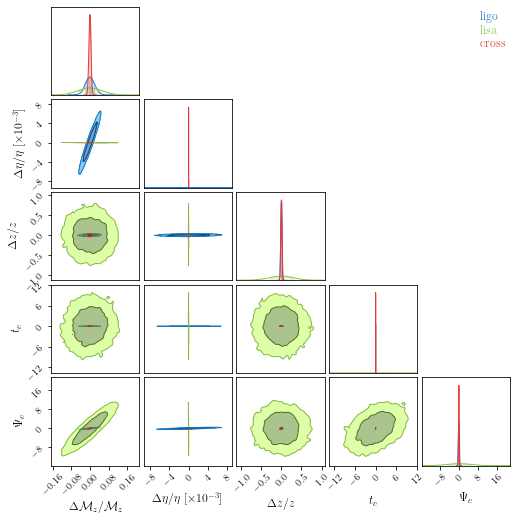

In [88]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR, name='lisa');
cc.add_chain(data_cross, bins=30, smooth=True, parameters=label_GR, name='cross');
cc.plotter.plot();

# Step function

In [89]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.1

In [90]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

In [91]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

h_Delta_step_w1_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step, cosmo_params)
h_Delta_step_w1_fid_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step_fid, cosmo_params)

h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params,dist_corr=False)

# For plotting only
h_Delta_step_w1_plot = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)

In [92]:
# Constraints for fiducial and non-fiducial models
ders_lisa_step = Fisher_der(farr_lisa, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)

fisher_lisa_step = Fisher_build(farr_lisa, lisa_psd, ders_lisa_step)
print(fisher_lisa_step)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)

- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
This took 1.35 seconds
[[ 9.82380488e+06  7.07626971e+10  1.53808001e+02 -3.09902483e+02
   1.99815119e+03  6.28273186e-14]
 [ 7.07626971e+10  5.10383055e+14  1.17961334e+06 -2.21302385e+06
   1.42629350e+07 -1.34672638e+01]
 [ 1.53808001e+02  1.17961334e+06  1.45458515e+01 -2.65110808e-17
   0.00000000e+00  2.16427356e+00]
 [-3.09902483e+02 -2.21302385e+06 -2.65110808e-17  8.59163303e-01
  -3.08493731e+00  7.31300292e-02]
 [ 1.99815119e+03  1.42629350e+07  0.00000000e+00 -3.08493731e+00
   1.45458515e+01 -3.68417926e-01]
 [ 6.28273186e-14 -1.34672638e+01  2.16427356e+00  7.31300292e-02
  -3.68417926e-01  1.79548622e+01]]
LISA step function
mod
[8.84691664e-03 1.22697630e-06 2.64676337e-01 2.21714248e+00


In [93]:
ders_ligo_step = Fisher_der(farr_ligo, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
#ders_ligo_step[1] *= 1.e-4       # reducing magnitude of dh/dlneta
fisher_ligo_step = Fisher_build(farr_ligo, ligo_psd, ders_ligo_step)


- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.34 seconds


In [94]:
fisher_tot = fisher_ligo_step +fisher_lisa_step
evals, evecs = np.linalg.eigh(fisher_tot)
print(evals)
### NO PROBLEM WITH THE CONDITIONING HERE!!!

[1.79522220e+01 1.05277411e+02 4.30901452e+03 3.02757209e+05
 3.33166995e+08 5.10383073e+14]


In [95]:
### NOW PLUG BACK DIST CORR!!!
ders_lisa_step_corr = Fisher_der(farr_lisa, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)

fisher_lisa_step_corr = Fisher_build(farr_ligo, ligo_psd, ders_lisa_step_corr)



- Working on index 0
Ratio best = 1.65e-14 for dx = 3.34e-01
Ratio best = 5.67e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 3.48e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 1.49e-03 for dx = 9.00e-02
Ratio best = 9.15e-16 for dx = 9.00e-02
This took 2.08 seconds


In [96]:
### THIS IS WHAT IS FAILING!!!
ders_ligo_step_corr = Fisher_der(farr_ligo, pars_step, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)

fisher_ligo_step_corr = Fisher_build(farr_ligo, ligo_psd, ders_ligo_step_corr)



- Working on index 0
Ratio best = 2.80e-14 for dx = 3.34e-01
Ratio best = 5.74e-03 for dx = 1.67e-01
- Working on index 1
Ratio best = 2.51e-03 for dx = 1.40e-01
- Working on index 2
- Working on index 3
- Working on index 4
- Working on index 5
This took 1.37 seconds


In [97]:
fisher_tot_corr = fisher_ligo_step_corr +fisher_lisa_step_corr
evals, evecs = np.linalg.eigh(fisher_tot_corr)
print(evals)

[-1.54746013e+26 -1.23583494e+14 -3.24478491e+07  6.79849882e+08
  1.54740077e+26  2.68532633e+43]


In [98]:
       # reducing magnitude of dh/dlneta
    ### There are some transposes on the Jacobian but here I forget them since it's all symmetric
    ### C = (J^(-1) J F J J^(-1))^(-1) = (J^(-1) F' J^(-1))^(-1) = J C' J 
new_ligo = np.array(ders_ligo_step_corr)
new_lisa = np.array(ders_lisa_step_corr)

mat        = np.identity(len(new_ligo))
mat[1,1]   = 1e-5
mat[2,2]   = 5e-10
mat[-1,-1] = 1e-10

new_lisa = np.matmul(mat, new_lisa)
new_ligo = np.matmul(mat, new_ligo)

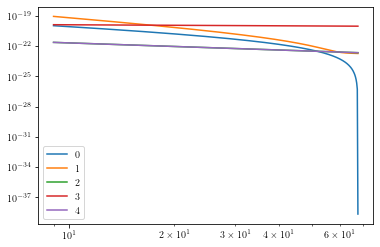

In [99]:
plt.figure()
for i in range(5):
    plt.loglog(farr_ligo, np.abs(ders_ligo_step_corr[i]), label=str(i))
plt.legend()

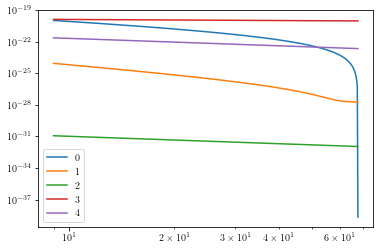

In [100]:
plt.figure()
for i in range(5):
    plt.loglog(farr_ligo, np.abs(new_ligo[i]), label=str(i))
plt.legend()

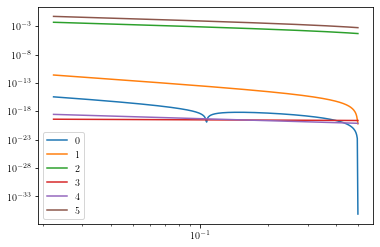

In [101]:
plt.figure()
for i in range(6):
    plt.loglog(farr_lisa, np.abs(ders_lisa_step_corr[i]), label=str(i))
plt.legend()

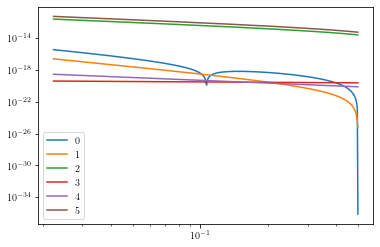

In [102]:
plt.figure()
for i in range(6):
    plt.loglog(farr_lisa, np.abs(new_lisa[i]), label=str(i))
plt.legend()

In [103]:
fisher_lisa_step_corr  = Fisher_build(farr_lisa, lisa_psd, new_lisa)
fisher_ligo_step_corr  = Fisher_build(farr_ligo, ligo_psd, new_ligo)

cross_corr = fisher_lisa_step_corr +fisher_ligo_step_corr

print(np.linalg.cond(cross_corr)/1e15)
evals, evecs = np.linalg.eigh(cross_corr)
print('\n', evals, '\n')
print(evecs[:,0])
print(evecs[:,-1])

42.37177617543491

 [9.91136752e-02 5.65192469e+01 1.36023130e+03 1.66120008e+06
 3.33167155e+08 6.16639186e+15] 

[-9.48706298e-05  1.49262783e-03  9.08929968e-01 -6.30892525e-06
 -2.19529282e-03  4.16940353e-01]
[ 3.70322404e-05  2.70560079e-06  4.16941823e-01 -1.01553561e-08
  4.85536730e-08 -9.08933174e-01]


In [104]:
fisher_lisa_step_corr_noc0  = Fisher_build(farr_lisa, lisa_psd, new_lisa[:-1])
fisher_ligo_step_corr_noc0  = Fisher_build(farr_ligo, ligo_psd, new_ligo[:-1])

cross_corr_noc0 = fisher_lisa_step_corr_noc0 +fisher_ligo_step_corr_noc0
print(np.linalg.cond(cross_corr_noc0)/1e15)


0.019001506661491713


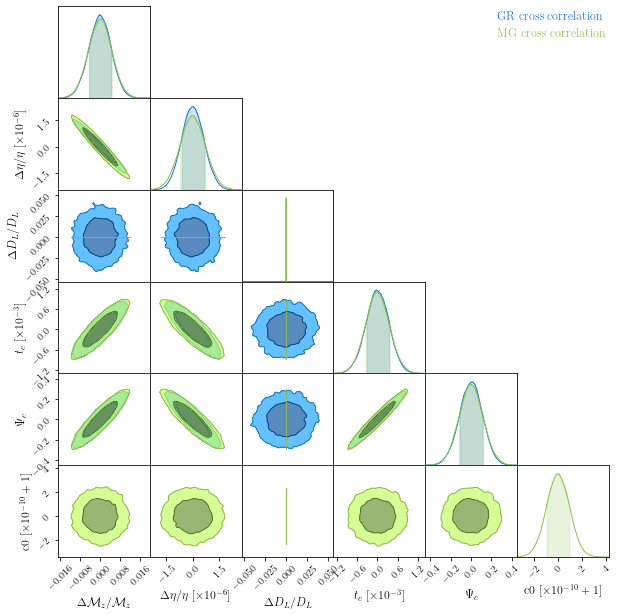

In [105]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta D_L/D_L$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

mat_noc0 = mat[:-1,:-1]

cov_mat_cross = np.matmul(np.matmul(mat, np.linalg.inv(cross_corr)), mat)

data_distcorr = np.random.multivariate_normal(fid_vals, cov_mat_cross, size=20000)

cc = ChainConsumer()

cc.add_chain(data_cross, bins=30, smooth=True, parameters=label[:-1], name='GR cross correlation');
cc.add_chain(data_distcorr, bins=30, smooth=True, parameters=label, name='MG cross correlation');
cc.plotter.plot();


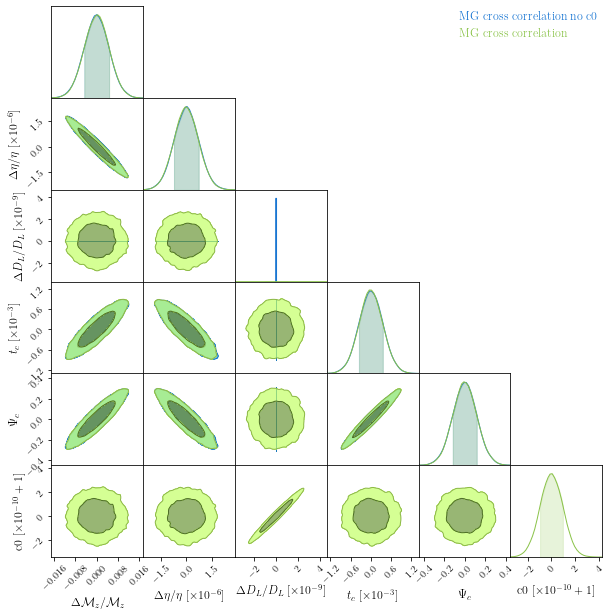

In [106]:
# MG LISA Fisher matrix for GR parameters with dist corr
mat_noc0 = mat[:-1,:-1]

cov_mat_cross_noc0 = np.matmul(np.matmul(mat_noc0, np.linalg.inv(cross_corr_noc0)), mat_noc0)

data_distcorr_noc0 = np.random.multivariate_normal(fid_vals_MG[:-1], cov_mat_cross_noc0, size=20000)

cc = ChainConsumer()

cc.add_chain(data_distcorr_noc0, bins=30, smooth=True, parameters=label[:-1], name='MG cross correlation no c0');
cc.add_chain(data_distcorr, bins=30, smooth=True, parameters=label, name='MG cross correlation');
cc.plotter.plot();

In [107]:
new_ligo_nodist = np.array(ders_ligo_step[:-1])
new_lisa_nodist = np.array(ders_lisa_step[:-1])

mat_nodist        = np.identity(len(new_ligo_nodist))
mat_nodist[1,1]   = 1e-5

new_lisa_nodist = np.matmul(mat_nodist, new_lisa_nodist)
new_ligo_nodist = np.matmul(mat_nodist, new_ligo_nodist)

fisher_lisa_step  = Fisher_build(farr_lisa, lisa_psd, new_lisa_nodist)
fisher_ligo_step  = Fisher_build(farr_ligo, ligo_psd, new_ligo_nodist)

cross_nodist = fisher_lisa_step +fisher_ligo_step

cov_mat_cross_nodist = np.matmul(np.matmul(mat_nodist, np.linalg.inv(cross_nodist)), mat_nodist)

print(np.linalg.cond(cross_nodist)/1e15)

3.9430516040965285e-09


In [108]:
new_ligo_nodist_c0 = np.array(ders_ligo_step)
new_lisa_nodist_c0 = np.array(ders_lisa_step)

mat_nodist_c0        = np.identity(len(new_ligo_nodist_c0))
mat_nodist_c0[1,1]   = 1e-5

new_lisa_nodist_c0 = np.matmul(mat_nodist_c0, new_lisa_nodist_c0)
new_ligo_nodist_c0 = np.matmul(mat_nodist_c0, new_ligo_nodist_c0)

fisher_lisa_step_c0  = Fisher_build(farr_lisa, lisa_psd, new_lisa_nodist_c0)
fisher_ligo_step_c0  = Fisher_build(farr_ligo, ligo_psd, new_ligo_nodist_c0)

cross_nodist_c0 = fisher_lisa_step_c0 +fisher_ligo_step_c0

cov_mat_cross_nodist_c0 = np.matmul(np.matmul(mat_nodist_c0, np.linalg.inv(cross_nodist_c0)), mat_nodist_c0)

print(np.linalg.cond(cross_nodist_c0)/1e15)

1.85586984680692e-08


In [109]:
constraint_GR = np.zeros(5)
constraint_MG_nodist = np.zeros(5)
constraint_MG_nodist_c0 = np.zeros(6)
constraint_MG_noc0 = np.zeros(5)
constraint_MG = np.zeros(6)

for i in range(5):
    constraint_GR[i] = cov_sum[i,i]
    constraint_MG_nodist[i] = cov_mat_cross_nodist[i,i]
    constraint_MG_noc0[i] = cov_mat_cross_noc0[i,i]

for i in range(6):
    constraint_MG[i] = cov_mat_cross[i,i]
    constraint_MG_nodist_c0[i] = cov_mat_cross_nodist_c0[i,i]

print('GR')
print(constraint_GR)
print('\nno dist corr no c0')
print(constraint_MG_nodist)
print('\nno dist corr with c0')
print(constraint_MG_nodist_c0)
print('\nwith dist corr no c0')
print(constraint_MG_noc0)
print('\nwith dist corr with c0')
print(constraint_MG)

GR
[1.89708494e-05 3.86745597e-13 2.32220465e-04 1.13930396e-07
 1.25278494e-02]

no dist corr no c0
[1.46476263e-05 2.86072663e-13 2.32071748e-04 8.76392238e-08
 9.48742873e-03]

no dist corr with c0
[1.46484375e-05 2.86088437e-13 2.32085785e-04 8.76452453e-08
 9.48810757e-03 5.57025775e-02]

with dist corr no c0
[2.09544092e-05 5.01192178e-13 2.29269462e-33 1.21139851e-07
 1.34287501e-02]

with dist corr with c0
[2.09544092e-05 5.01192178e-13 1.09000000e-18 1.21139851e-07
 1.34287501e-02 9.17431193e-21]
